In [1]:
import tensorflow.keras as keras
from tensorflow.keras import initializers,regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import math
import matplotlib.pylab as plt
import matplotlib
from random import random
from sklearn.utils import resample
import smogn

In [2]:
import numpy as np
import pandas as pd

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
def new_df(df,mass):
    df['mass'] = [mass for i in range(len(df))]
    df['log_energy'] = np.log10(df['energy'])
    df['cos_zenith'] = np.cos(df['zenith'])
    df['log_energy_loss'] = np.log10(df['energy_loss'])
    df['log_m_r'] = np.log10(df['m_r'])
    df['log_charge'] = np.log10(df['charge'])
    df['log_A'] = np.log10(df['A'])
    m_o = df['m_o'].values
    m_125 = df['m_125'].values
    new = [abs(i-j) for i,j in zip(df['firstint'],df['Xo'])]
    difference = np.array([(i-j) for i,j in zip(df['s_o'],df['m_s'])])
    df['new'] = new
    df['new_s125'] = [i + 125*j for i,j in zip(df['s_o'],df['s_r'])]
    df = df.loc[(df['Xmax']<900)&
                (df['Xmax']>400)&
                (df['S125']>0)&
                (df['fit_status_m']!=0)&
                (df['fit_status_m']!=2)&
                (df['fit_status_s']!=0)&
                (df['m_chi2']<1)&
                (df['s_chi2']<0.1)&
                (abs(difference)<0.5)&
                (abs(df['m_r'])<5e-3)&
                (df['m_125']>0)&
                (df['m_125']<5)&
                (df['m_s']>=0.25)&
                (df['m_s']<1.5)&
                (df['m_s2']>0)&
                (df['m_s2']<20)&
                (df['s_o']>0.5)&
                (df['s_o']<1)&
                (abs(df['s_r'])<0.01)&
               (df['zenith']<45*(np.pi/180))]
    return df

In [5]:
def new_df_data(df):
    df['cos_zenith'] = np.cos(df['zenith'])
    df['log_energy_loss'] = np.log10(df['energy_loss'])
    df['log_m_r'] = np.log10(df['m_r'])
    df['log_charge'] = np.log10(df['charge'])
    df['log_A'] = np.log10(df['A'])
    m_o = df['m_o'].values
    m_125 = df['m_125'].values
    difference = np.array([(i-j) for i,j in zip(df['s_o'],df['m_s'])])
    df['new_s125'] = [i + 125*j for i,j in zip(df['s_o'],df['s_r'])]
    df = df.loc[
                (df['S125']>0.5)&
                (df['fit_status_m']!=0)&
                (df['fit_status_m']!=2)&
                (df['fit_status_s']!=0)&
                (df['m_chi2']<1)&
                (df['s_chi2']<0.1)&
                (abs(difference)<0.5)&
                (abs(df['m_r'])<5e-3)&
                (df['m_125']>0)&
                (df['m_125']<5)&
                (df['m_s']>=0.25)&
                (df['m_s']<1.5)&
                (df['m_s2']>0)&
                (df['m_s2']<20)&
                (df['s_o']>0.5)&
                (df['s_o']<1)&
                (abs(df['s_r'])<0.01)&
               (df['zenith']<45*(np.pi/180))]
    return df

In [6]:
def binning(x,y,bins,name=None,plot=False,bins_input=[]):
    check1 = list(zip(x,y))
    if len(bins_input)!=0:
        hist1 = np.histogram(x,bins=bins_input)
    else:
        hist1 = np.histogram(x,bins=bins)
    mean = [[] for i in range(len(hist1[1][0:len(hist1[1])-1]))]
    mean_count = np.zeros(len(mean))
    index = range(len(mean))
    for i in check1:
        for j in index:
            if (i[0] > hist1[1][j] and i[0] < hist1[1][j+1]):
                mean[j].append( i[1])
                mean_count[j]+=1

    new_dist_10 = []
    new_dist_90 =  []
    check = []
    for j in mean:
        if len(j) == 0:
            check.append(False)
            continue
        else:
            check.append(True)
        dist10 = []
        dist90 = []
        for k in range(100):
            new_sample = resample(j)
            dist10.append(np.quantile(new_sample,0.25))
            dist90.append(np.quantile(new_sample,0.75))
        new_dist_10.append(dist10)
        new_dist_90.append(dist90)
    mean_overall = np.array([np.mean(i) for i in mean])[check]
    std_mean = np.array([np.std(i) for i in mean])[check]
    median = np.array([np.median(i) for i in mean])[check]
    ten = [np.mean(i) for i in new_dist_10]
    ninety = [np.mean(i) for i in new_dist_90]
    
    bins = np.array(hist1[1][0:len(hist1[1])-1])[check]
    if plot:
        mean1 = 0
        std1 = 0
        for j in range(len(mean)):
            plot_value = [(i-mean_overall[j]) for i in mean[j]]
            mean1+=abs(np.mean(plot_value))
            std1+=abs(np.std(plot_value))
            plt.hist(plot_value,bins=20,label="mean: %f \n std: %f"%(np.mean(plot_value),np.std(plot_value)))
            plt.xlabel('Residual')
            plt.title(name+'%.2f to %.2f'%(hist1[1][j],hist1[1][j+1]))
            plt.xlim(-100,100)
            plt.legend()
            #plt.savefig(name+'_%.2f.png'%(hist1[1][j]))
            plt.show()
            plt.clf()
        print(mean1/len(mean),std1/len(mean))
    return mean_overall,std_mean,bins,median,ten,ninety

In [7]:
def binning2(x,y,bins,bins_input=[]):
    check1 = list(zip(x,y))
    if len(bins_input)!=0:
        hist1 = np.histogram(x,bins=bins_input)
    else:
        hist1 = np.histogram(x,bins=bins)
    mean = [[] for i in range(len(hist1[1][0:len(hist1[1])-1]))]
    mean_count = np.zeros(len(mean))
    index = range(len(mean))
    for i in check1:
        for j in index:
            if (i[0] > hist1[1][j] and i[0] < hist1[1][j+1]):
                mean[j].append( i[1])
                mean_count[j]+=1

    new_dist_10 = []
    new_dist_90 =  []
    check = []
    for j in mean:
        if len(j) == 0:
            check.append(False)
            continue
        else:
            check.append(True)
        dist10 = []
        dist90 = []
        for k in range(100):
            new_sample = resample(j)
            dist10.append(np.quantile(new_sample,0.25))
            dist90.append(np.quantile(new_sample,0.75))
        new_dist_10.append(dist10)
        new_dist_90.append(dist90)
    mean_overall = np.array([np.mean(i) for i in mean])[check]
    std_mean = np.array([np.std(i) for i in mean])[check]
    median = np.array([np.median(i) for i in mean])[check]
    ten = [np.mean(i) for i in new_dist_10]
    ninety = [np.mean(i) for i in new_dist_90]
    FWHM = [2*(2*np.log(2))**0.5 * np.std(i) for i in mean]
    
    bins = np.array(hist1[1][0:len(hist1[1])-1])[check]

    return mean_overall,std_mean,bins,median,ten,ninety,FWHM

In [8]:
iron = pd.read_csv('Iron.csv')
proton = pd.read_csv('Proton.csv')
helium = pd.read_csv('Helium.csv')
oxygen = pd.read_csv('Oxygen.csv')
proton2 = pd.read_csv('Proton2.csv')
iron2 =  pd.read_csv('Iron2.csv')
proton3 = pd.read_csv('Proton3.csv')
iron3 = pd.read_csv('Iron3.csv')
proton4 = pd.read_csv('Proton4.csv')
iron4 = pd.read_csv('Iron4.csv')

In [9]:
data = pd.read_csv('data.csv')

In [10]:
iron.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_r', 's_o', 's_chi2',
       'fit_status_s', 'charge', 'N', 'ghRedChiSqr', 'firstint', 'max_check',
       'new_xmax', 'new_xo', 'new_lambda', 'fit_status', 'new_chi2',
       'difference', 'MaxNum', 'waveform_weight'],
      dtype='object')

In [11]:
iron = new_df(iron,4)
proton = new_df(proton,1)
helium = new_df(helium,2)
oxygen = new_df(oxygen,3)
proton2 = new_df(proton2,1)
iron2 = new_df(iron2,4)
proton3 = new_df(proton3,1)
iron3 = new_df(iron3,4)
proton4 = new_df(proton4,1)
iron4 = new_df(iron4,4)

/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
data = new_df_data(data)

In [13]:
from sklearn.cluster import KMeans
import seaborn

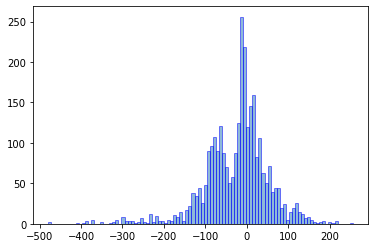

In [14]:
plt.hist(proton['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Proton_Xo.png')

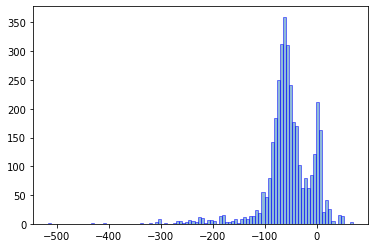

In [15]:
plt.hist(iron['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Iron_Xo.png')

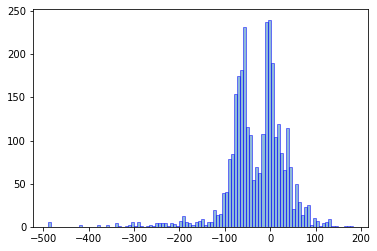

In [16]:
plt.hist(helium['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Helium_Xo.png')

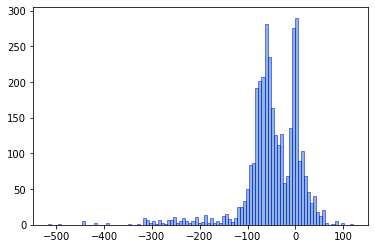

In [17]:
plt.hist(oxygen['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Oxygen_Xo.png')

In [18]:
df = iron.append(proton)
df = df.append(helium)
df = df.append(oxygen)
#df = df.append(proton2)
#df = df.append(iron2)
#df = df.append(proton3)
#df = df.append(iron3)
#df = df.append(proton4)
#df = df.append(iron4)

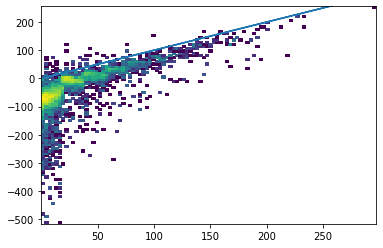

In [19]:
plt.hist2d(df['firstint'],df['Xo'],bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(df['firstint'],df['firstint'])
plt.show()

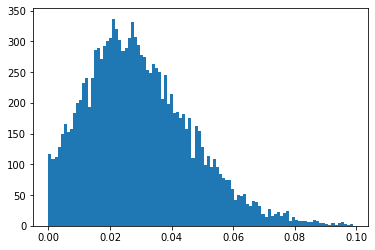

In [20]:
plt.hist(df['s_chi2'][(df['s_chi2']<0.1)&(df['s_chi2']>1e-5)],bins=100)
plt.show()

In [21]:
df['log_energy'] = df['log_energy'].values

In [22]:
df.head()

,Unnamed: 0,mass,energy,zenith,S125,energy_loss,he_stoch,he_stoch2,Xmax,Xo,...,MaxNum,waveform_weight,log_energy,cos_zenith,log_energy_loss,log_m_r,log_charge,log_A,new,new_s125
0,0,4,33181566.0,0.380478,1.568851,186.599907,3,1,554.648804,19.267458,...,14792975.0,1.280572,7.520897,0.928487,2.270911,NaN,3.287585,-3.313512,30.399626,0.824305
1,1,4,33181566.0,0.384414,1.596185,144.241157,4,0,554.648804,19.267458,...,14792975.0,1.675668,7.520897,0.927018,2.159089,-3.797366,2.981812,-3.233955,30.399626,0.777079
2,2,4,92080440.0,0.094941,2.065233,430.736401,10,0,553.176270,-70.772858,...,39844120.0,1.000000,7.964167,0.995496,2.634212,NaN,3.744920,-3.296734,76.730209,1.121549
3,3,4,92080440.0,0.086432,2.098824,552.119408,9,0,553.176270,-70.772858,...,39844120.0,1.000000,7.964167,0.996267,2.742033,-3.039789,3.902943,-3.193633,76.730209,0.754733
4,4,4,92080440.0,0.092143,2.099362,368.223424,8,0,553.176270,-70.772858,...,39844120.0,1.000000,7.964167,0.995758,2.566111,-2.757014,3.700785,-3.208765,76.730209,0.990948


In [23]:
check = [math.isnan(i)==0 for i in df['log_energy_loss'].values]

In [24]:
check_data = [math.isnan(i)==0 for i in data['log_energy_loss'].values]

In [25]:
df_coinc = df[check]

In [26]:
df_coinc = df_coinc.reset_index()

In [27]:
data_coinc = data[check_data]
data_coinc = data_coinc.reset_index()

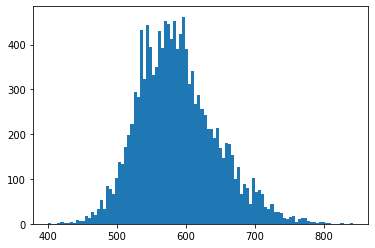

In [28]:
plt.hist(df_coinc['Xmax'],bins=100)
plt.show()

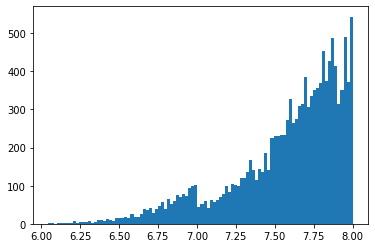

In [29]:
plt.hist(df['log_energy'],bins=100)
plt.show()

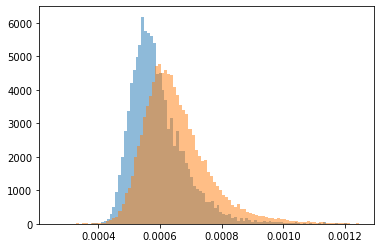

In [30]:
plt.hist(df_coinc['A'][(df_coinc['A']>2.5e-4)&(df_coinc['A']<1.25e-3)],bins=100,alpha=0.5,density=True)
plt.hist(data_coinc['A'][(data_coinc['A']>2.5e-4)&(data_coinc['A']<1.25e-3)],bins=100,alpha=0.5,density=True)
plt.show()

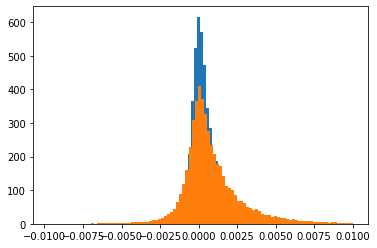

In [31]:
plt.hist(df_coinc['s_r'],bins=100,density=True)
plt.hist(data_coinc['s_r'],bins=100,density=True)
plt.show()

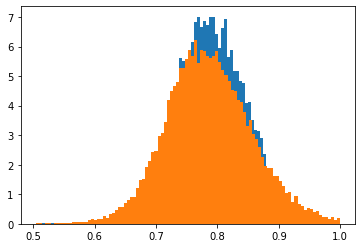

In [32]:
plt.hist(df_coinc['s_o'][abs(df_coinc['s_o'])<1],bins=100,density=True)
plt.hist(data_coinc['s_o'],bins=100,density=True)
plt.show()

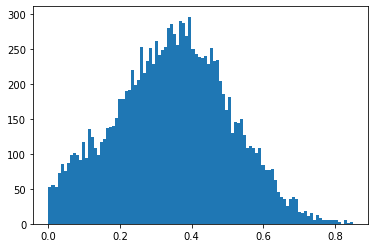

In [33]:
plt.hist(df_coinc['m_chi2'][df_coinc['m_chi2']<1],bins=100)
plt.show()

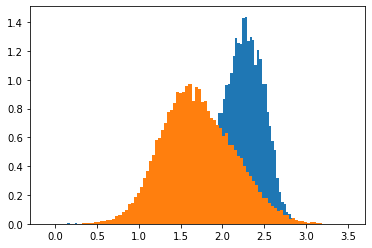

In [34]:
plt.hist(df_coinc['log_energy_loss'],bins=100,density=True)
plt.hist(data_coinc['log_energy_loss'],bins=100,density=True)
plt.show()

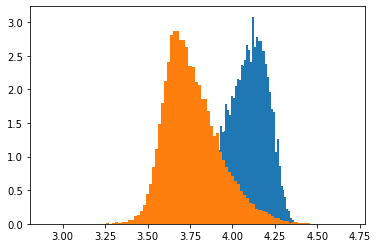

In [35]:
plt.hist(df_coinc['m_o'],bins=100,density=True)
plt.hist(data_coinc['m_o'],bins=100,density=True)
plt.show()

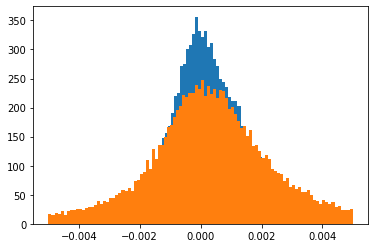

In [36]:
plt.hist(df_coinc['m_r'],bins=100,density=True)
plt.hist(data_coinc['m_r'],bins=100,density=True)
plt.show()

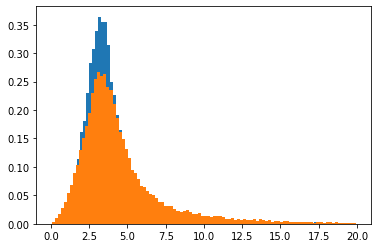

In [37]:
plt.hist(df_coinc['m_s2'],bins=100,density=True)
plt.hist(data_coinc['m_s2'],bins=100,density=True)
plt.show()

In [38]:
difference = np.array([(i-j) for i,j in zip(df_coinc['s_o'],df_coinc['m_s'])])

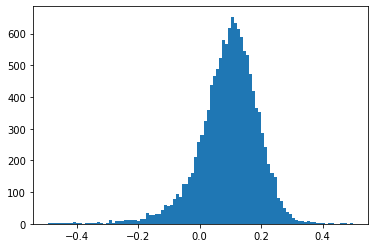

In [39]:
plt.hist(difference[abs(difference)<0.5],bins=100)
plt.show()

In [40]:
a,b,c,d,e,f = binning(df_coinc['log_energy'].values,df_coinc['m_chi2'].values,bins=30)

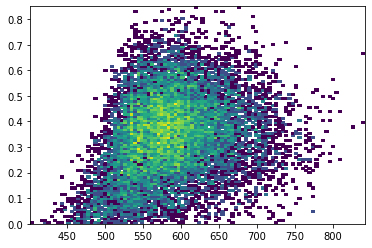

In [41]:
plt.hist2d(df_coinc['Xmax'].values,df_coinc['m_chi2'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

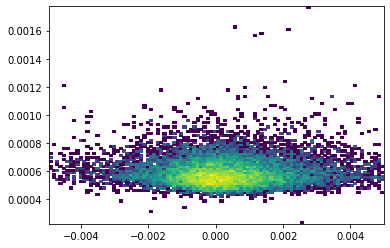

In [42]:
plt.hist2d(df_coinc['m_r'].values,df_coinc['A'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

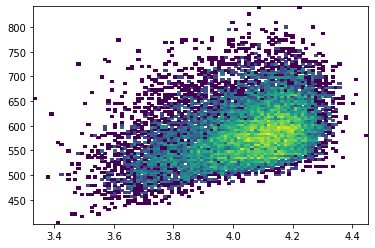

In [43]:
plt.hist2d(df_coinc['m_o'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

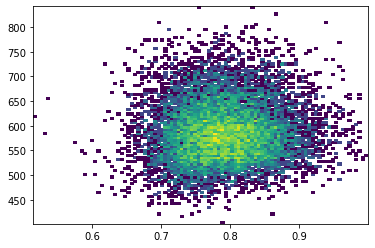

In [44]:
plt.hist2d(df_coinc['s_o'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

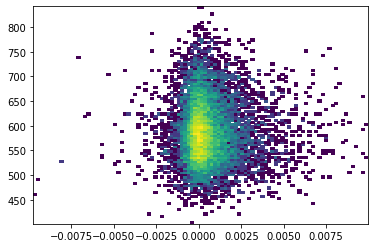

In [45]:
plt.hist2d(df_coinc['s_r'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

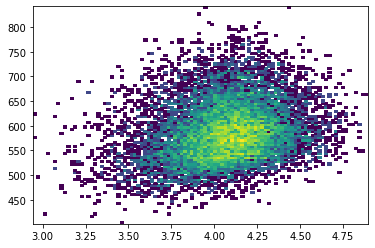

In [46]:
plt.hist2d(df_coinc['m_125'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

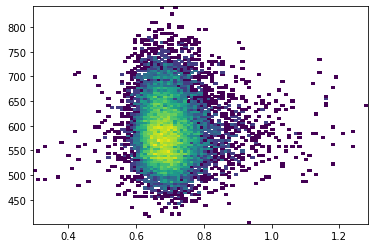

In [47]:
plt.hist2d(df_coinc['m_s'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

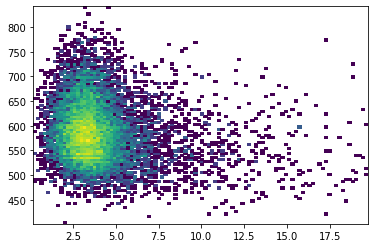

In [48]:
plt.hist2d(df_coinc['m_s2'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

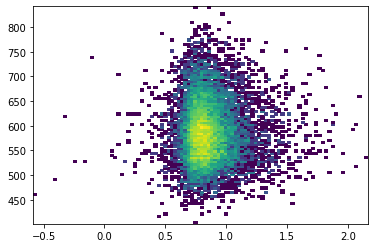

In [49]:
plt.hist2d(df_coinc['new_s125'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

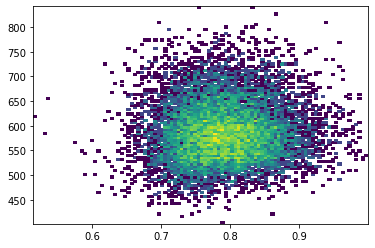

In [50]:
plt.hist2d(df_coinc['s_o'].values,df_coinc['Xmax'].values,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(c,a,color='r')
plt.show()

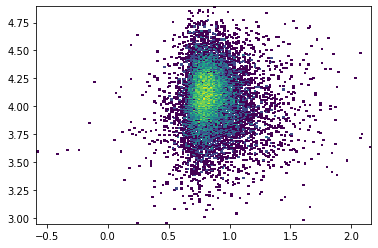

In [51]:
plt.hist2d(df_coinc['new_s125'].values,df_coinc['m_125'].values,bins=200,norm=matplotlib.colors.LogNorm())
plt.show()

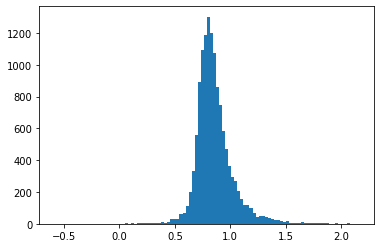

In [52]:
plt.hist(df_coinc['new_s125'],bins=100)
plt.show()

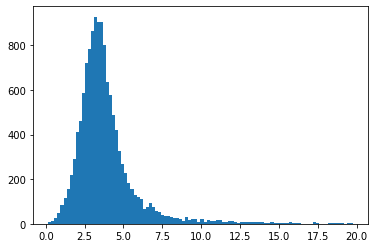

In [53]:
plt.hist(df_coinc['m_s2'][df_coinc['m_s2']>0],bins=100)
plt.show()

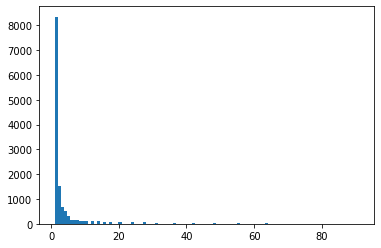

In [54]:
plt.hist(df_coinc['waveform_weight'],bins=100)
plt.show()

In [55]:
df_coinc.corr()[['Xmax','log_energy','new_xmax','Xo','firstint','A','m_chi2']]

,Xmax,log_energy,new_xmax,Xo,firstint,A,m_chi2
index,-0.070432,-0.026648,-0.030557,-0.013952,-0.044935,-0.005507,-0.017966
Unnamed: 0,-0.070432,-0.026648,-0.030557,-0.013952,-0.044935,-0.005507,-0.017966
mass,-0.594556,-0.009186,-0.266409,-0.187192,-0.411917,-0.237849,0.025182
energy,0.356496,0.919461,0.272277,-0.020467,-0.032548,-0.327696,0.713045
zenith,0.012128,-0.027140,0.023455,-0.088400,-0.014707,-0.100186,-0.079952
S125,0.363081,0.992281,0.256440,-0.027310,-0.054838,-0.343261,0.767325
energy_loss,-0.161732,0.669042,0.015114,-0.188015,-0.319505,-0.412344,0.529870
he_stoch,-0.068800,0.369741,0.017234,-0.059598,-0.153143,-0.154538,0.264231
he_stoch2,-0.035443,0.094092,-0.011567,-0.013737,-0.042865,-0.031709,0.026237
Xmax,1.000000,0.369918,0.496678,0.299662,0.603845,0.199452,0.240191


In [56]:
from sklearn.model_selection import train_test_split

In [57]:
validation = df_coinc.sample(frac=0.1,random_state=42)

In [58]:
validation_y =  validation[['log_energy','Xmax','Xo','mass']].values
validation_X = validation[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_o','m_r','m_s','m_s2','m_125','A']].values

In [59]:
df_coinc = df_coinc.drop(validation.index)
df_coinc = df_coinc.reset_index()

In [60]:
y = df_coinc[['log_energy','Xmax','Xo','mass']].values
X = df_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_o','m_r','m_s','m_s2','m_125','A','waveform_weight']].values

In [61]:
X_data = data_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_o','m_r','m_s','m_s2','m_125','A']].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
X_train

array([[9.51971010e-01, 1.53580147e+00, 2.23603907e+00, ...,
        3.84021509e+00, 4.98771807e-04, 4.06595433e+00],
       [9.25129469e-01, 1.90063030e+00, 2.40216846e+00, ...,
        3.91924452e+00, 5.60807160e-04, 1.56324391e+00],
       [9.60807879e-01, 1.90537131e+00, 2.36097132e+00, ...,
        4.31648180e+00, 5.53620210e-04, 1.00000000e+00],
       ...,
       [9.70451427e-01, 2.04558101e+00, 2.30048300e+00, ...,
        3.97705317e+00, 5.88085327e-04, 1.46058478e+00],
       [9.18639363e-01, 1.22974571e+00, 2.15035670e+00, ...,
        4.02234601e+00, 6.02176324e-04, 2.43207364e+00],
       [9.67513844e-01, 1.81510892e+00, 2.26512866e+00, ...,
        4.43108426e+00, 5.25721151e-04, 1.46058478e+00]])

In [64]:
variable = list(zip(*X_train))
#weight = np.array(variable[-1])
X_train = X_train[:,0:-1]
X_test = X_test[:,0:-1]

In [65]:
weight = []
for i in y_train:
    if i[0] == 1:
        weight.append(1)
    elif i[0] == 2:
        weight.append(len(proton)/len(helium))
    elif i[0] == 3:
        weight.append(len(proton)/len(oxygen))
    else:
        weight.append(len(proton)/len(iron))
weight=np.array(weight)

In [66]:
model_best = 'model_coinc_best.h5'

best_model = keras.callbacks.ModelCheckpoint(model_best,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto')

es = EarlyStopping(monitor='val_loss',patience=20)

input_layer = Input(shape=(len(X_train[0]),))

model1 = BatchNormalization()(input_layer)

model1 = Dense(12,bias_regularizer=keras.regularizers.l1(1e-1))(model1)

model1 = LeakyReLU(alpha=0.2)(model1)

model2 = BatchNormalization()(model1)

model2 = Dense(7)(model2)

model2 = LeakyReLU(alpha=0.2)(model2)

model3 = Concatenate(axis=-1,activity_regularizer=keras.regularizers.l2(1e-5))([input_layer,model2])

model3 = Dropout(0.5)(model3)

model3 = BatchNormalization(renorm=True)(model3)

prediction1 = Dense(4,activation='linear',kernel_regularizer = keras.regularizers.l2(1e-5))(model3)

model = Model(inputs=input_layer,outputs=prediction1)

opt = keras.optimizers.Adam(decay=1e-5)

model.compile(optimizer=opt , loss = 'mse')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [67]:
history = model.fit(X_train,y_train[:,0:4],
                    epochs=200,
                    shuffle=True,
                    validation_data = (X_test,y_test[:,0:4]),
                    callbacks=[best_model,es],
                    sample_weight=weight)

Train on 9383 samples, validate on 2346 samples
Epoch 1/200
9383/9383 [==============================] - 1s 105us/sample - loss: 71936.2932 - val_loss: 87586.2848
Epoch 2/200
9383/9383 [==============================] - 0s 43us/sample - loss: 70752.4323 - val_loss: 85119.2621
Epoch 3/200
9383/9383 [==============================] - 0s 43us/sample - loss: 67889.7694 - val_loss: 80696.6838
Epoch 4/200
9383/9383 [==============================] - 0s 43us/sample - loss: 63438.0637 - val_loss: 74441.3642
Epoch 5/200
9383/9383 [==============================] - 0s 44us/sample - loss: 57866.9131 - val_loss: 67085.4674
Epoch 6/200
9383/9383 [==============================] - 0s 48us/sample - loss: 51609.3596 - val_loss: 59252.2445
Epoch 7/200
9383/9383 [==============================] - 0s 42us/sample - loss: 44935.6012 - val_loss: 50809.9008
Epoch 8/200
9383/9383 [==============================] - 0s 41us/sample - loss: 38231.7717 - val_loss: 43284.8859
Epoch 9/200
9383/9383 [================

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

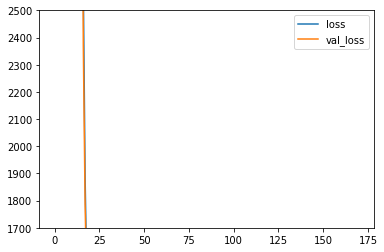

In [69]:
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.ylim(1700,2500)
plt.savefig('loss_curve.png')

In [70]:
best_model = load_model('model_coinc_best.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


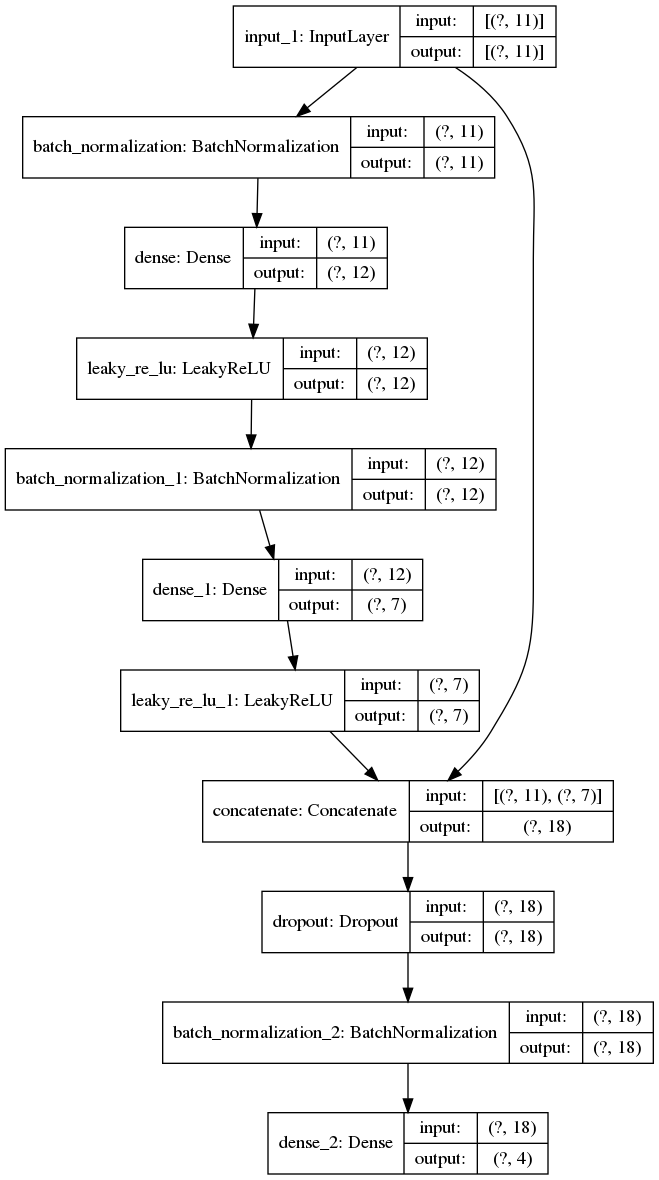

In [71]:
from tensorflow.keras.utils import plot_model
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [72]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [73]:
tree =BaggingRegressor(DecisionTreeRegressor(splitter='best',max_features='log2',random_state=42),n_estimators=400,bootstrap=True,random_state=42)

In [74]:
tree.fit(X_train,y_train[:,0])

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='log2',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=42,
                                                      splitter='best'),
                 bootstrap=T

In [75]:
predictions = best_model.predict(X_test)

In [76]:
predictions2 = tree.predict(X_test)

In [77]:
energy_predictions = predictions2
energy = np.array(list(zip(*y_test))[0])
xmax = np.array(list(zip(*y_test))[1])
x_o = np.array(list(zip(*y_test))[2])
x_o_pred = np.array(list(zip(*predictions))[2])
xmax_predictions = np.array(list(zip(*predictions))[1])
mass = np.array(list(zip(*y_test))[3])

In [78]:
from scipy.optimize import curve_fit
def line_function(x,m,b):
    return m * x + b
def quadratic_function(x,m,b):
    y = b + m * x
    return y

In [79]:
value = [(i-j) for i,j in zip(xmax_predictions,xmax)]

In [80]:
degrees = np.arccos(list(zip(*X_test))[0])*180/np.pi

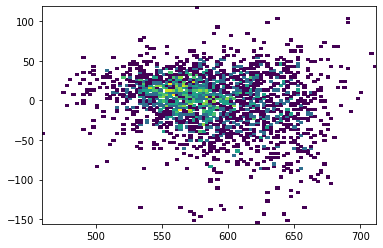

In [81]:
plt.hist2d(xmax_predictions,value,bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [82]:
validation_xmax = np.array(list(zip(*validation_y)))[1]
mass2 = np.array(list(zip(*validation_y)))[2]
X_test_new = [np.hstack([i,j]) for i,j in zip(X_test,xmax_predictions)]
validation_X_new = [np.hstack([i,j]) for i,j in zip(validation_X,validation_xmax)]

In [83]:
check_predictions = best_model.predict(validation_X)
check_predictions2 = tree.predict(validation_X)

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
line_model = LinearRegression()

In [86]:
line_model.fit(xmax_predictions.reshape(-1,1),value)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [87]:
bias = line_model.predict(xmax_predictions.reshape(-1,1))
bias2 = line_model.predict(validation_xmax.reshape(-1,1))

In [88]:
xmax_predictions = np.array([(i-j) for i,j in zip(xmax_predictions,bias)])
xmax_predictions2 = np.array([(i-j) for i,j in zip(list(zip(*check_predictions))[1],bias2)])

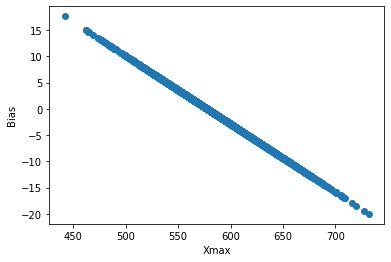

In [89]:
plt.scatter(xmax_predictions,bias)
plt.xlabel('Xmax')
plt.ylabel('Bias')
plt.savefig('Bias.png')

In [90]:
#xmax_predictions2 = list(zip(*check_predictions))[1]

In [91]:
import matplotlib

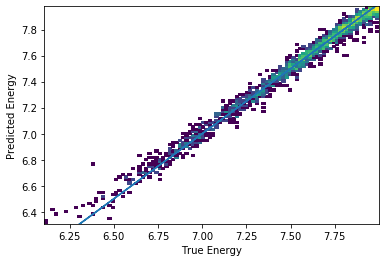

In [92]:
plt.hist2d(energy,energy_predictions,bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.plot(energy,energy)
plt.savefig('Energy_resolution.png')

In [93]:
error_energy = [(i-j)**2 for i,j in zip(energy_predictions,energy)]

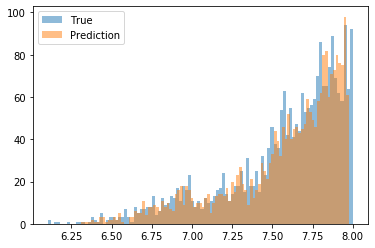

In [94]:
plt.hist(energy,bins=100,alpha=0.5,label='True')
plt.hist(energy_predictions,bins=100,alpha=0.5,label='Prediction')
plt.legend()
plt.show()

In [95]:
mean_overall,std_mean,bins,median,ten,ninety,FWHM = binning2(energy,error_energy,bins=20)

In [96]:
rmse_new = [i**0.5 for i in mean_overall]

In [97]:
std_new = [(1/(2*mean))*sigma for mean,sigma in zip(rmse_new,std_mean)]

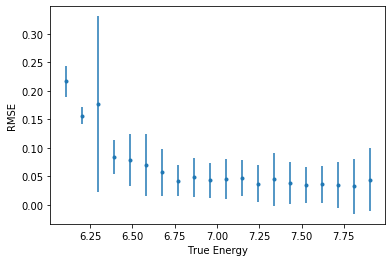

In [98]:
plt.errorbar(bins,rmse_new,yerr=std_new,fmt='.')
plt.xlabel('True Energy')
plt.ylabel('RMSE')
plt.savefig('Energy.png')

In [99]:
np.corrcoef(energy,energy_predictions)[0][1]

0.9935559907332452

In [100]:
print(np.mean([(i-j)**2 for i,j in zip(energy,energy_predictions)])**0.5)

0.042552536176886355


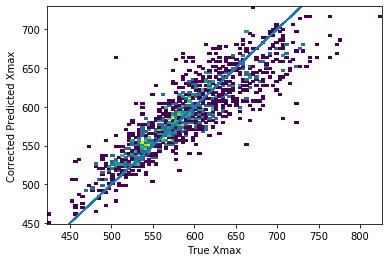

In [101]:
plt.hist2d(validation_xmax,xmax_predictions2,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(validation_xmax,validation_xmax)
plt.xlabel('True Xmax')
plt.ylabel('Corrected Predicted Xmax')
plt.savefig('True_vs_predicted_after.png')
plt.show()

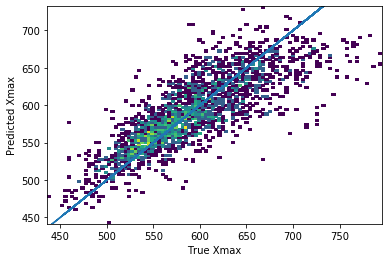

In [102]:
plt.hist2d(xmax,xmax_predictions,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(xmax,xmax)
plt.xlabel('True Xmax')
plt.ylabel('Predicted Xmax')
plt.show()

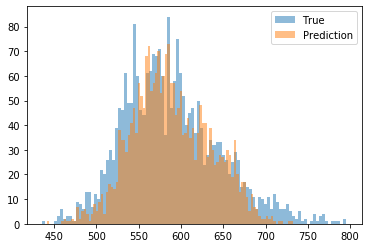

In [103]:
plt.hist(xmax,bins=100,alpha=0.5,label='True')
plt.hist(xmax_predictions,bins=100,alpha=0.5,label='Prediction')
plt.legend()
plt.show()

In [104]:
error_xmax = [(i-j)**2 for i,j in zip(validation_xmax,xmax_predictions2)]

In [105]:
data_predict = best_model.predict(X_data)
xmax_data = list(zip(*data_predict))[1]

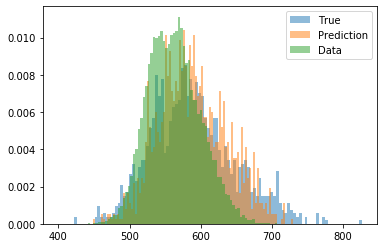

In [106]:
plt.hist(validation_xmax,bins=100,alpha=0.5,label='True',density=True)
plt.hist(xmax_predictions2,bins=100,alpha=0.5,label='Prediction',density=True)
plt.hist(xmax_data,bins=100,alpha=0.5,label='Data',density=True)
plt.legend()
plt.show()

In [107]:
len(validation_xmax)

1303

In [108]:
mean_overall,std_mean,bins,median,ten,ninety,FWHM = binning2(validation_xmax,error_xmax,bins=10)

/home/andy/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/andy/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [109]:
rmse_new = [i**0.5 for i in mean_overall]
std_new = [(1/(2*mean))*sigma for mean,sigma in zip(rmse_new,std_mean)]

In [110]:
FWHM_2 = [i/2 for i in FWHM]

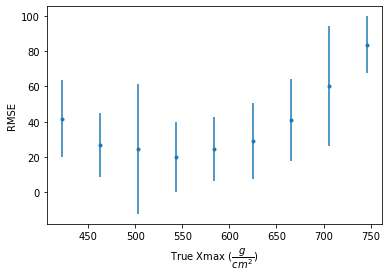

In [111]:
plt.errorbar(bins,rmse_new,yerr=std_new,fmt='.')
plt.xlabel('True Xmax ($\\dfrac{g}{cm^2})$')
plt.ylabel('RMSE')
plt.savefig('FWHM.png')

In [112]:
degrees = np.arccos(list(zip(*validation_X))[0])*180/np.pi
error = [abs(i-j) for i,j in zip(validation_xmax,xmax_predictions2)]

In [113]:
mean_overall,std_mean,bins,median,ten,ninety,FWHM = binning2(degrees,error,bins=15)

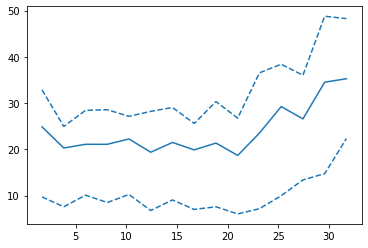

In [114]:
plot = plt.errorbar(bins,mean_overall)
color = plot[0].get_color()
plt.plot(bins,ten,color=color,linestyle='dashed')
plt.plot(bins,ninety,color=color,linestyle='dashed')
plt.show()

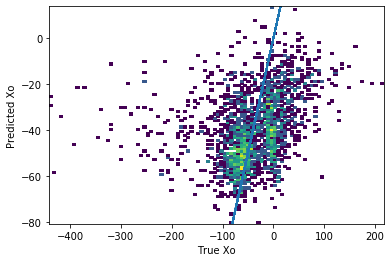

In [115]:
plt.hist2d(x_o,x_o_pred,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(x_o,x_o)
plt.xlabel('True Xo')
plt.ylabel('Predicted Xo')
plt.show()

In [116]:
np.corrcoef(xmax,xmax_predictions)[0][1]

0.8072243837210202

In [117]:
mean_xmax,std_xmax,bins_xmax,median_xmax,ten_xmax,ninety_xmax = binning(xmax,xmax_predictions,20,plot=False)

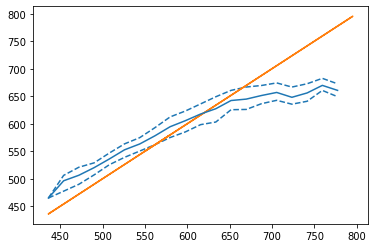

In [118]:
plot = plt.errorbar(bins_xmax,mean_xmax,label='proton')
color = plot[0].get_color()
plt.plot(bins_xmax,ten_xmax,linestyle='dashed',color=color)
plt.plot(bins_xmax,ninety_xmax,linestyle='dashed',color=color)
plt.plot(xmax,xmax)
plt.show()

In [119]:
mse = np.mean([(i-j)**2 for i,j in zip(xmax,xmax_predictions)])
print(mse**0.5)

33.43116387175453


In [120]:
np.corrcoef(validation_xmax,xmax_predictions2)[0][1]

0.8772394259097782

In [121]:
check = (energy_predictions>=0)

In [122]:
predictions = predictions[check]

In [123]:
mass = mass[check]

In [124]:
energy = np.array(energy)

In [125]:
mass_predictions = list(zip(*predictions))[3]

In [126]:
mass_predictions2 = np.array(list(zip(*check_predictions))[3])

In [127]:
iron_energy = predictions2[mass==4]
proton_energy = predictions2[mass==1]
helium_energy = predictions2[mass==2]
oxygen_energy= predictions2[mass==3]

In [128]:
iron_xmax = np.array(xmax_predictions)[mass==4]
proton_xmax = np.array(xmax_predictions)[mass==1]
helium_xmax = np.array(xmax_predictions)[mass==2]
oxygen_xmax = np.array(xmax_predictions)[mass==3]

In [129]:
iron_mass2 = np.array(mass_predictions2)[mass2==4]
proton_mass2 = np.array(mass_predictions2)[mass2==1]
helium_mass2 = np.array(mass_predictions2)[mass2==2]
oxygen_mass2 = np.array(mass_predictions2)[mass2==3]

In [130]:
iron_mass = np.array(mass_predictions)[mass==4]
proton_mass = np.array(mass_predictions)[mass==1]
helium_mass = np.array(mass_predictions)[mass==2]
oxygen_mass = np.array(mass_predictions)[mass==3]

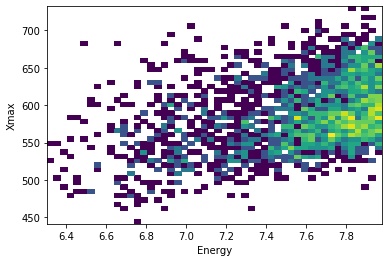

In [131]:
Xmax_predicted = xmax_predictions
check = (Xmax_predicted>400)&(Xmax_predicted<900)
plt.hist2d(predictions2[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

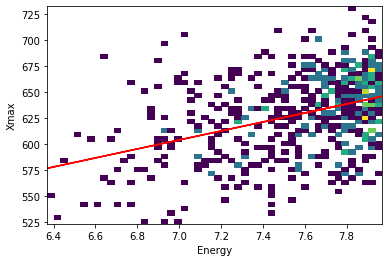

43.23315019619033 300.99200064118907


In [132]:
Xmax_predicted = proton_xmax
check_proton = (Xmax_predicted>400)&(Xmax_predicted<900)
fit_proton = curve_fit(line_function,proton_energy[check_proton],Xmax_predicted[check_proton])
output_xmax_proton = line_function(proton_energy[check_proton],fit_proton[0][0],fit_proton[0][1])

plt.hist2d(proton_energy[check_proton],Xmax_predicted[check_proton],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(proton_energy[check_proton],output_xmax_proton,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit_proton[0][0],fit_proton[0][1])

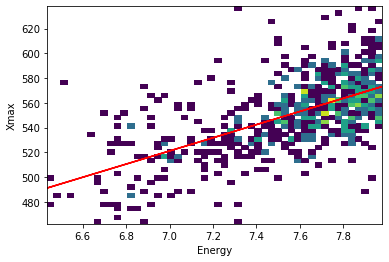

53.153324130968 149.0688681165934


In [133]:
Xmax_predicted = iron_xmax
check_iron = (Xmax_predicted>400)&(Xmax_predicted<900)
fit_iron = curve_fit(line_function,iron_energy[check_iron],Xmax_predicted[check_iron])
output_xmax_iron = line_function(iron_energy[check_iron],fit_iron[0][0],fit_iron[0][1])

plt.hist2d(iron_energy[check_iron],Xmax_predicted[check_iron],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(iron_energy[check_iron],output_xmax_iron,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit_iron[0][0],fit_iron[0][1])

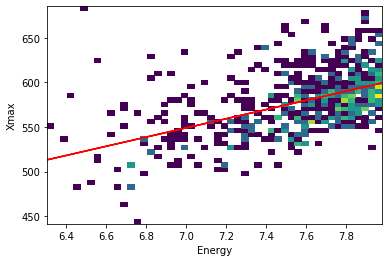

51.57774930204844 187.8454718143761


In [134]:
Xmax_predicted = oxygen_xmax
check = (Xmax_predicted>400)&(Xmax_predicted<900)
fit = curve_fit(line_function,oxygen_energy[check],Xmax_predicted[check])
output_xmax = line_function(oxygen_energy[check],fit[0][0],fit[0][1])

plt.hist2d(oxygen_energy[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(oxygen_energy[check],output_xmax,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit[0][0],fit[0][1])

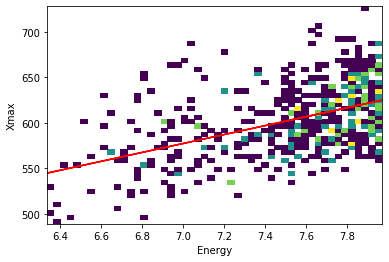

49.000706725051636 234.18227126612794


In [135]:
Xmax_predicted = helium_xmax
check = (Xmax_predicted>400)&(Xmax_predicted<900)
fit = curve_fit(line_function,helium_energy[check],Xmax_predicted[check])
output_xmax = line_function(helium_energy[check],fit[0][0],fit[0][1])

plt.hist2d(helium_energy[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(helium_energy[check],output_xmax,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit[0][0],fit[0][1])

In [136]:
plot = False
bins = 10
mean_proton,std_proton,bins_proton,median_proton,ten_proton,ninety_proton = binning(proton_energy,proton_xmax,bins,name='proton',plot=plot)
mean_iron,std_iron,bins_iron,median_iron,ten_iron,ninety_iron = binning(iron_energy,iron_xmax,bins,name='iron',plot=plot,bins_input=list(bins_proton))
mean_oxygen,std_oxygen,bins_oxygen,median_oxygen,ten_oxygen,ninety_oxygen = binning(oxygen_energy,oxygen_xmax,bins,name='oxygen',plot=plot,bins_input=bins_proton)
mean_helium,std_helium,bins_helium,median_helium,ten_helium,ninety_helium = binning(helium_energy,helium_xmax,bins,name='helium',plot=plot,bins_input=bins_proton)

In [137]:
len(proton_energy)

543

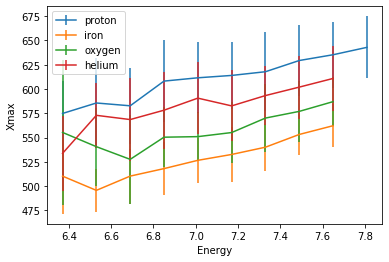

In [138]:
plt.errorbar(bins_proton,mean_proton,yerr=std_proton,label='proton')
plt.errorbar(bins_iron,mean_iron,yerr=std_iron,label='iron')
plt.errorbar(bins_oxygen,mean_oxygen,yerr=std_oxygen,label='oxygen')
plt.errorbar(bins_helium,mean_helium,yerr=std_helium,label='helium')
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('All_species_energy_xmax3.png')
#plt.show()

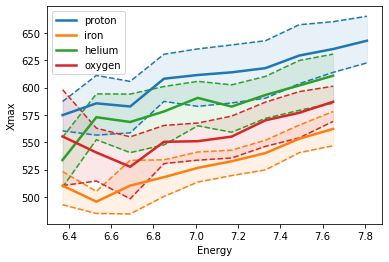

In [139]:
plot = plt.errorbar(bins_proton,mean_proton,label='proton',linewidth=2.5)
color = plot[0].get_color()
plt.plot(bins_proton,ten_proton,linestyle='dashed',color=color)
plt.plot(bins_proton,ninety_proton,linestyle='dashed',color=color)
plt.fill_between(bins_proton,(ten_proton),(ninety_proton),alpha=0.1,color=color)

plot = plt.errorbar(bins_iron,mean_iron,label='iron',linewidth=2.5)
color = plot[0].get_color()
plt.plot(bins_iron,ten_iron,linestyle='dashed',color=color)
plt.plot(bins_iron,ninety_iron,linestyle='dashed',color=color)
plt.fill_between(bins_iron,(ten_iron),(ninety_iron),alpha=0.1,color=color)

plot = plt.errorbar(bins_helium,mean_helium,label='helium',linewidth=2.5)
color = plot[0].get_color()
plt.plot(bins_helium,ten_helium,linestyle='dashed',color=color)
plt.plot(bins_helium,ninety_helium,linestyle='dashed',color=color)
plt.fill_between(bins_helium,(ten_helium),(ninety_helium),alpha=0.1,color=color)

plot = plt.errorbar(bins_oxygen,mean_oxygen,label='oxygen',linewidth=2.5)
color = plot[0].get_color()
plt.plot(bins_oxygen,ten_oxygen,linestyle='dashed',color=color)
plt.plot(bins_oxygen,ninety_oxygen,linestyle='dashed',color=color)
plt.fill_between(bins_oxygen,(ten_oxygen),(ninety_oxygen),alpha=0.1,color=color)

plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('New_plot.png')

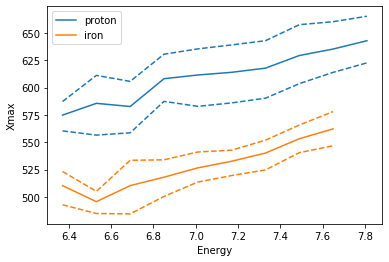

In [140]:
plot = plt.errorbar(bins_proton,mean_proton,label='proton')
color = plot[0].get_color()
plt.plot(bins_proton,ten_proton,linestyle='dashed',color=color)
plt.plot(bins_proton,ninety_proton,linestyle='dashed',color=color)

plot = plt.errorbar(bins_iron,mean_iron,label='iron')
color = plot[0].get_color()
plt.plot(bins_iron,ten_iron,linestyle='dashed',color=color)
plt.plot(bins_iron,ninety_iron,linestyle='dashed',color=color)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('Proton_vs_Iron.png')
#plt.show()